CONVOLUTION REVERB

convolving an input signal with an input impulse response

In [20]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import simpleaudio as sa
from matplotlib.pyplot import figure
import math
import utility

### Reading in Input Audio Signal

In [21]:
"""initiating some local .wav files"""

mono = "/Users/anniechu/Desktop/CantinaBand3.wav"
# mono = "/Users/anniechu/Downloads/PinkPanther30.wav"
stereo = "/Users/anniechu/Desktop/MutedPop.wav"

In [22]:
"""choosing & reading in input signal .wav file"""

input_sig = mono
fs_in, data_in = wavfile.read(input_sig)

In [23]:
"""FUNCTION: display_data() -- checking data contents (mono vs stereo)""" 
#works both mono & stereo
def display_data(audiofile, showgraphs = True):
    fs_in, data_in = wavfile.read(audiofile)
    print(f".Wav Contents = {data_in}")
    print(f".Wav Samples Length = {data_in.shape[0]}")
    print(f".Wav Channel(s) = {len(data_in.shape)}")
    length = data_in.shape[0] / fs_in
    print(f".Wav Length = {length}s")
    print(f"Sampling Rate= {fs_in} Hz")
    print(f"bit depth= {type(data_in[0])}")
    print(f"sampling rate = {fs_in} Hz, length = {data_in.shape[0]} samples => {data_in.shape[0]/fs_in} s, channels = {len(data_in.shape)}")

    if showgraphs == True:
        plt.plot(data_in);
        plt.title(str(audiofile));
        plt.xlabel("Samples");
        plt.ylabel("Amplitude");

.Wav Contents = [   3    7    0 ...  -12 -427 -227]
.Wav Samples Length = 66150
.Wav Channel(s) = 1
.Wav Length = 3.0s
Sampling Rate= 22050 Hz
bit depth= <class 'numpy.int16'>
sampling rate = 22050 Hz, length = 66150 samples => 3.0 s, channels = 1


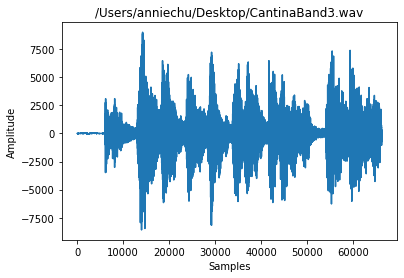

In [24]:
""" displaying input signal .wav file contents """
display_data(input_sig, showgraphs=True)

In [25]:
"""function to read sound depending on # of channels in input signal .wav file"""

def play_sound(audiofile):
    fs_in, data_in = wavfile.read(audiofile)
    num_chan = len(data_in.shape)
    if num_chan == 1:
        playwav = sa.play_buffer(data_in, 1, 2, fs_in)
        return playwav
    elif num_chan == 2:
        playwav = sa.play_buffer(data_in, 2, 2, fs_in)
        return playwav

In [26]:
""" playing input sig .wav sample sound """
input_sig = mono #choose mono vs stereo as defined previously
x = play_sound(input_sig)

In [27]:
""" stopping input sig .wav sample sound """
x.stop()

### Reading in Impulse Response (IR) Signal

In [28]:
""" initiating sample Impulse Response .wav files """

ir1 = "/Users/anniechu/Documents/artificialreverb/WireGrind-IR-44100-v2/mono/WireGrind_m_0.8s_06w_900Hz_02m.wav"
ir2 = "xyx"
IR = ir1

In [29]:
""" loading in IR .wav file data and sampling rate """
fs_IR, data_IR = wavfile.read(IR)

.Wav Contents = [2147483392    -139264    -365824 ...      13568       8704      40448]
.Wav Samples Length = 35280
.Wav Channel(s) = 1
.Wav Length = 0.8s
Sampling Rate= 44100 Hz
bit depth= <class 'numpy.int32'>
sampling rate = 44100 Hz, length = 35280 samples => 0.8 s, channels = 1


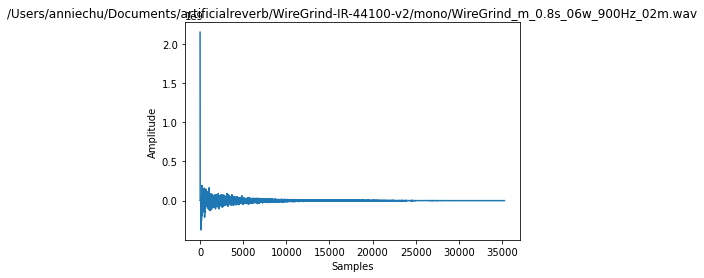

In [30]:
display_data(IR)

### Matching Sampling Frequencies (Pre-Convolution Prep)

In [31]:
"""
FUNCITON match_fs: calculating diff in fs factor, returns upsampling factor & which data to upsample
"""

def match_fs(input_fs, IR_fs, input_sig, IR):
    upsamp= IR_fs/input_fs; #IR fs divided by fs_in -- if > 1, IR has higher fs; if < 1 data_in has higher fs
    upsamp_data = 0;
    data_name = 0;
    if input_fs > IR_fs: #if samp rate of data is greater than samp rate of IR, take reciprocal
        upsamp = 1/upsamp;
        upsamp_data = IR;
        data_name = "IR";
#         print("upsample_data: data_IR")

    else:
        upsamp_data = input_sig;
        data_name = "input_sig";

#         print("upsample_data: data_in")

    return int(upsamp), upsamp_data, data_name

In [32]:
print(fs_in)
print(fs_IR)
upsamp_factor, upsamp_data_todo, upsamp_data_todoname = match_fs(fs_in, fs_IR, data_in, data_IR)
print(f"upsampling factor = {upsamp_factor}, data to upsample = ({upsamp_data_todoname}) || {upsamp_data_todo}")

22050
44100
upsampling factor = 2, data to upsample = (input_sig) || [   3    7    0 ...  -12 -427 -227]


In [33]:
from scipy.interpolate import interp1d
"""
upsampling dataset as given by match_fs function
"""

def upsample(upsamp, up_data, showgraphs = False):
    k = np.arange(len(up_data))
    
    #inserting zeros in between original sample
    n = up_data.shape
    size = n[0]
    out = np.zeros(upsamp*size, dtype = int)
    out[::upsamp] = up_data
    k_up = np.arange(len(out))

    
    #upsampling & interpolation
    data_interp = np.interp(k_up, k_up[out!=0], out[out!=0])
#     print(f"New Upsamp&Interp Data = {data_interp}, upsamp factor = {upsamp}" )

    if showgraphs==True:
        plt.figure() #original signal
        plt.plot(k,up_data)
        plt.ylim([-4000, 4000])
        plt.xlabel('Sample [k]')
        plt.ylabel('amplitude')
        plt.title('original signal')
        
        plt.figure() #upsampled signal -- inserted 0s
        plt.plot(k_up,out)
        plt.ylim([-4000, 4000])
        plt.xlabel('Sample [k]')
        plt.ylabel('amplitude')
        plt.title('upsampled signal')
        
        plt.figure() #interpolated signal -- output
        plt.plot(k_up,out)
        plt.plot(k_up, data_interp)
        plt.xlim([15000, 16000])
        plt.ylim([-4000, 4000])
        plt.xlabel('Sample [k]')
        plt.ylabel('amplitude')
        plt.title('interpolated signal')
        plt.legend(['upsampled', "interpolated"])
    
    data_out = data_interp.astype(np.int16)

    return data_out
# upsample(fs_in, fs_IR, data_in, data_IR)

array([   3,    5,    7, ..., -327, -227, -227], dtype=int16)

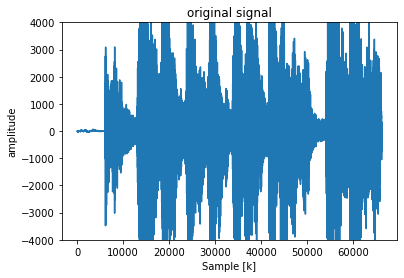

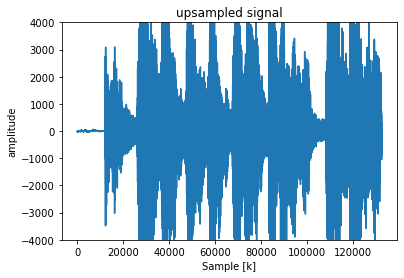

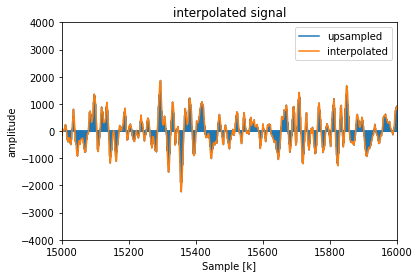

In [34]:
upsample(upsamp_factor, upsamp_data_todo, showgraphs=True)

In [35]:
sig_upsampd = upsample(upsamp_factor, upsamp_data_todo)
print(sig_upsampd)

[   3    5    7 ... -327 -227 -227]


In [ ]:
#stereo
def full_upsample(input_fs, IR_fs, input_sig, IR):
    for i in len(input_sig.shape):
        

### Normalizing Signals (Pre-Convolution Prep)

##### PCM to Float [-1,1] Conversion

In [17]:
"""
FUNCTION: using utility to convert int16 to float32 as convolving large numbers takes up too long
"""
def norm_signals(sig, IR):
    normalized_sig = utility.pcm2float(sig, "float32")
    normalized_IR = utility.pcm2float(IR, "float32")

    return normalized_sig, normalized_IR

Dry Sig PCM = [   3    7    0 ...  -12 -427 -227]
Dry Sig NORM = [ 9.1552734e-05  1.5258789e-04  2.1362305e-04 ... -9.9792480e-03
 -6.9274902e-03 -6.9274902e-03]
IR PCM = [2147483392    -139264    -365824 ...      13568       8704      40448]
IR NORM = [ 9.99999881e-01 -6.48498535e-05 -1.70350075e-04 ...  6.31809235e-06
  4.05311584e-06  1.88350677e-05]


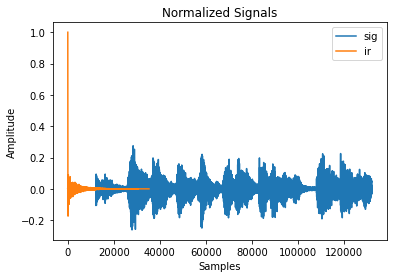

In [18]:
#normalizing upsampled signal & IR # -------- MUST WRITE IN WHICH SIGNAL IS UPSAMPLED -- 
drysig_norm, IR_norm = norm_signals(sig_upsampd, data_IR)
print(f"Dry Sig PCM = {data_in}")
print(f"Dry Sig NORM = {drysig_norm}")
print(f"IR PCM = {data_IR}")
print(f"IR NORM = {IR_norm}")
plt.plot(drysig_norm);
plt.plot(IR_norm);
plt.title("Normalized Signals");
plt.xlabel("Samples");
plt.ylabel("Amplitude");
plt.legend(["sig", "ir"])

### Convolving Signals

[ 9.15541770e-05  1.52573543e-04  2.13606153e-04 ... -2.61401951e-07
 -1.55388204e-07 -1.38109198e-07]


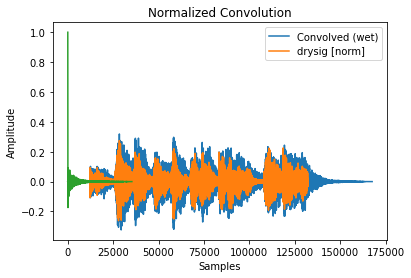

In [19]:
#convolving normalized version of input signal with 
wet_sig = signal.convolve(drysig_norm, IR_norm, mode='full', method='auto')
print(wet_sig)
plt.plot(wet_sig);
plt.plot(drysig_norm)
plt.plot(IR_norm)
plt.title("Normalized Convolution");
plt.xlabel("Samples");
plt.ylabel("Amplitude");
plt.legend(["Convolved (wet)", "drysig [norm]"])

In [21]:
print(len(wet_sig), len(drysig_norm),len(data_in))

167579 132300 66150


### Mixing Dry & Wet Signals

In [22]:
"""*** downsampling and mixing with original signal"""
#mono
wet_sig_ds = [wet_sig[i] for i in range(len(wet_sig)) if i % upsamp_factor == 0]
wet_sig_ds = np.asarray(wet_sig_ds)
print(len(wet_sig), len(wet_sig_ds), type(wet_sig_ds), wet_sig_ds)

167579 83790 <class 'numpy.ndarray'> [ 9.15541770e-05  2.13606153e-04  1.83067404e-04 ... -5.57257250e-07
 -2.61401951e-07 -1.38109198e-07]


In [34]:
"""dry signal padding ---- hereeeee""" 

#mono
data_in_norm = utility.pcm2float(data_in, "float32")

shape = np.shape(data_in_norm)
drysig_padded = np.zeros((len(wet_sig_ds)))
drysig_padded[:shape[0]] = data_in_norm #dry sig is padded data_in

#stereo
# drysig = np.zeros((len(down_wet_sig), 2))
# drysig[:shape[0],:shape[1]] = data_in

print(drysig_padded)


[9.15527344e-05 2.13623047e-04 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


[ 9.15541770e-05  2.13606153e-04  1.83067404e-04 ... -5.57257250e-07
 -2.61401951e-07 -1.38109198e-07]
[ 9.1552734e-05  1.5258789e-04  2.1362305e-04 ... -9.9792480e-03
 -6.9274902e-03 -6.9274902e-03]
[ 9.15537442e-05  2.13611221e-04  1.28147183e-04 ... -3.90080075e-07
 -1.82981365e-07 -9.66764386e-08]


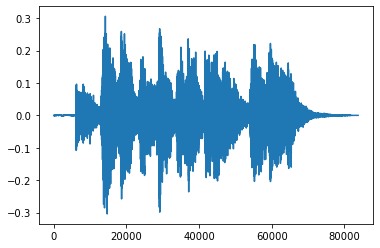

In [35]:
#is this right
wetvsdry = 0.7
mixed = (wetvsdry*wet_sig_ds) + (1-wetvsdry)*drysig_padded
print(wet_sig_ds)
print(drysig_norm)
print(mixed) 
plt.plot(mixed)

In [38]:
#converting convolved signal from float64 back to int16
wet_sig_int = utility.float2pcm(wet_sig, 'int16')
mixed_int = utility.float2pcm(mixed, 'int16')
print(mixed_int)
print(f"Old Conv Sig type = {mixed.dtype}")
print(f"New Conv Sig type = {mixed_int.dtype}")
print(len(wet_sig_int))

NameError: name 'wet_sig' is not defined

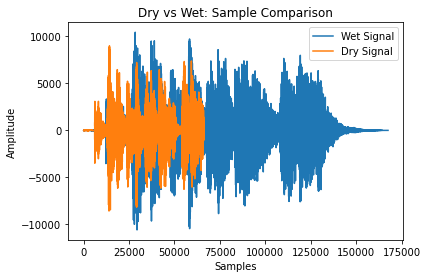

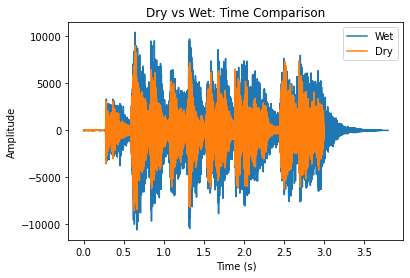

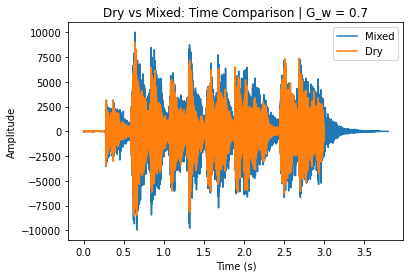

In [44]:
"""plotting dry vs wet vs mixed signal"""

plt.plot(wet_sig_int, label = "Wet Signal");
plt.plot(data_in, label = "Dry Signal");
plt.legend();
plt.xlabel("Samples");
plt.ylabel("Amplitude");
plt.title("Dry vs Wet: Sample Comparison")

t_dry = np.arange(0, len(data_in)/fs_in, (len(data_in)/fs_in)/len(data_in))
t_wet = np.arange(0, len(wet_sig_int)/fs_IR, (len(wet_sig_int)/fs_IR)/len(wet_sig_int))
t_mix = np.arange(0, len(drysig_padded)/fs_in, (len(drysig_padded)/fs_in)/len(drysig_padded))

plt.figure()
plt.plot(t_wet,wet_sig_int, label = "Wet");
plt.plot(t_dry, data_in, label = "Dry");
plt.legend();
plt.xlabel("Time (s)");
plt.ylabel("Amplitude");
plt.title("Dry vs Wet: Time Comparison")

plt.figure()
plt.plot(t_mix, mixed_int, label = "Mixed")
plt.plot(t_dry, data_in, label = "Dry");
plt.legend();
plt.xlabel("Time (s)");
plt.ylabel("Amplitude");
plt.title(f"Dry vs Mixed: Time Comparison | G_w = {wetvsdry}");


In [45]:
mix = sa.play_buffer(mixed_int, 1, 2, fs_in)

In [46]:
mix.stop()

In [47]:
wet = sa.play_buffer(wet_sig_int, 1, 2, fs_IR)

In [48]:
wet.stop()

In [49]:
dry = sa.play_buffer(data_in, 1, 2, fs_in)

In [50]:
dry.stop()

In [ ]:
# ----- STEREO (in progress) ---------

In [ ]:
#that audio file is mono, so we're gonna make it stereo by copying it
new_data_in = np.stack((data_in, data_in), axis=-1)

In [ ]:
#new stereo data
print(f".Wav Contents = {new_data_in}")
print(f".Wav Shape = {new_data_in.shape}")
length = new_data_in.shape[0] / fs_in
print(f".Wav Length = {length}s")
print(f"Sampling Rate= {fs_in} Hz")

print(f"bit depth= {type(new_data_in[0][0])}")

#playing stereo
play_obj = sa.play_buffer(new_data_in, 2, 2, fs_in)


-----
"""add in original dry mix. conv_reverb is just the wet aspect."""
"""try using scipy interp1d"""
"""work for both stereo and mono"""
"""general clean up -- dont hard code"""